In [3]:
# Install required packages (uncomment if needed)
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install torch-geometric
!pip install networkx matplotlib seaborn plotly pandas numpy scikit-learn
!pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cpu.html# Install required packages (uncomment if needed)

Looking in indexes: https://download.pytorch.org/whl/cpu
/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cpu.html# Install required packages (uncomment if needed)'


In [4]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGEConv, GATConv
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx, train_test_split_edges
from torch_geometric.datasets import KarateClub

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cpu
PyTorch version: 2.9.0+cu126


In [5]:
# Option 1: Load Karate Club dataset (small, classic social network)
print("Loading Karate Club Dataset...")
dataset = KarateClub()
data = dataset[0]

print(f"\nDataset: {dataset}")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Number of features: {data.num_node_features}")
print(f"Number of classes: {dataset.num_classes}")
print(f"\nData object: {data}")
print(f"\nNode feature matrix shape: {data.x.shape}")
print(f"Edge index shape: {data.edge_index.shape}")

Loading Karate Club Dataset...

Dataset: KarateClub()
Number of nodes: 34
Number of edges: 156
Number of features: 34
Number of classes: 4

Data object: Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])

Node feature matrix shape: torch.Size([34, 34])
Edge index shape: torch.Size([2, 156])


In [6]:
# Option 2: Create a synthetic social network using NetworkX
print("Creating Synthetic Social Network...")

# Create a random social network graph
G = nx.karate_club_graph()
# Alternative: G = nx.les_miserables_graph()
# Alternative: G = nx.davis_southern_women_graph()

print(f"Graph nodes: {G.number_of_nodes()}")
print(f"Graph edges: {G.number_of_edges()}")
print(f"Graph density: {nx.density(G):.3f}")
print(f"Average clustering: {nx.average_clustering(G):.3f}")

Creating Synthetic Social Network...
Graph nodes: 34
Graph edges: 78
Graph density: 0.139
Average clustering: 0.571


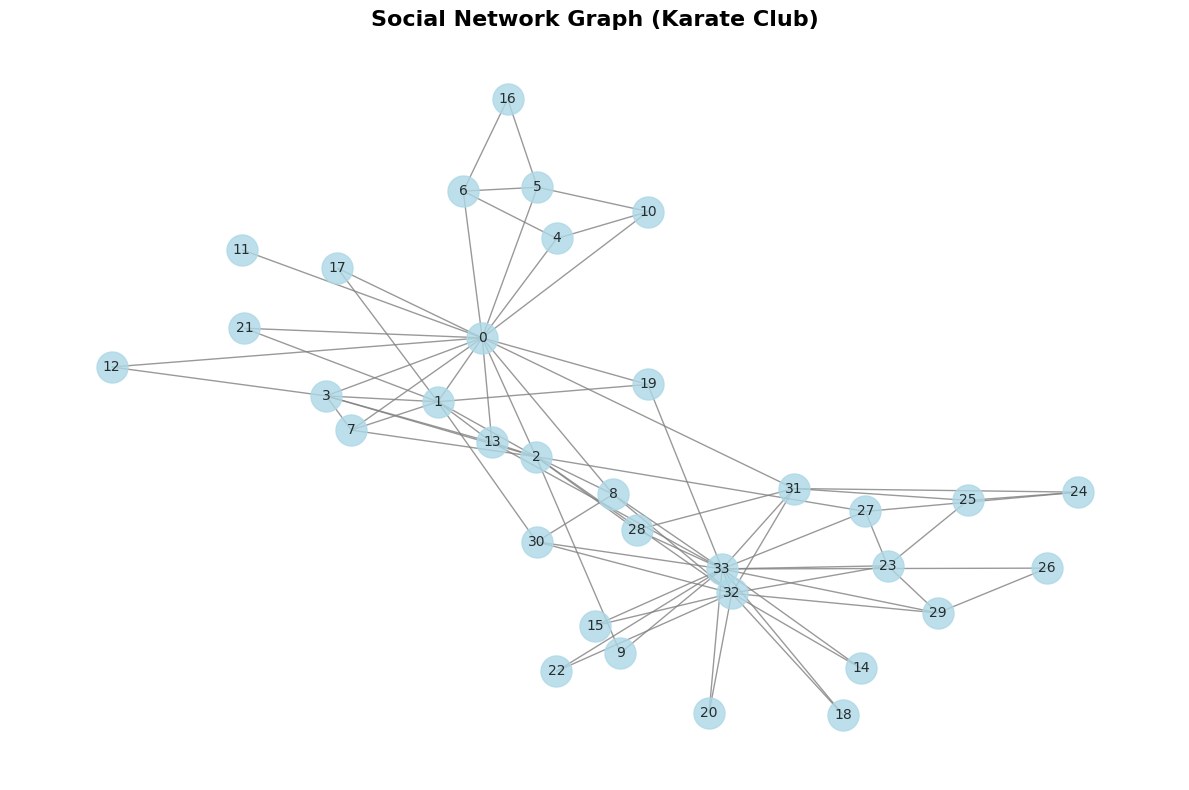

In [7]:
# Visualize the original graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx(G, pos,
                node_color='lightblue',
                node_size=500,
                edge_color='gray',
                with_labels=True,
                font_size=10,
                alpha=0.8)
plt.title('Social Network Graph (Karate Club)', fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

In [8]:
# Analyze graph properties
print("Graph Statistics:")
print(f"Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")
print(f"Diameter: {nx.diameter(G)}")
print(f"Average path length: {nx.average_shortest_path_length(G):.2f}")
print(f"\nDegree distribution:")
degrees = [G.degree(n) for n in G.nodes()]
print(f"Min degree: {min(degrees)}")
print(f"Max degree: {max(degrees)}")
print(f"Mean degree: {np.mean(degrees):.2f}")

Graph Statistics:
Average degree: 4.59
Diameter: 5
Average path length: 2.41

Degree distribution:
Min degree: 1
Max degree: 17
Mean degree: 4.59


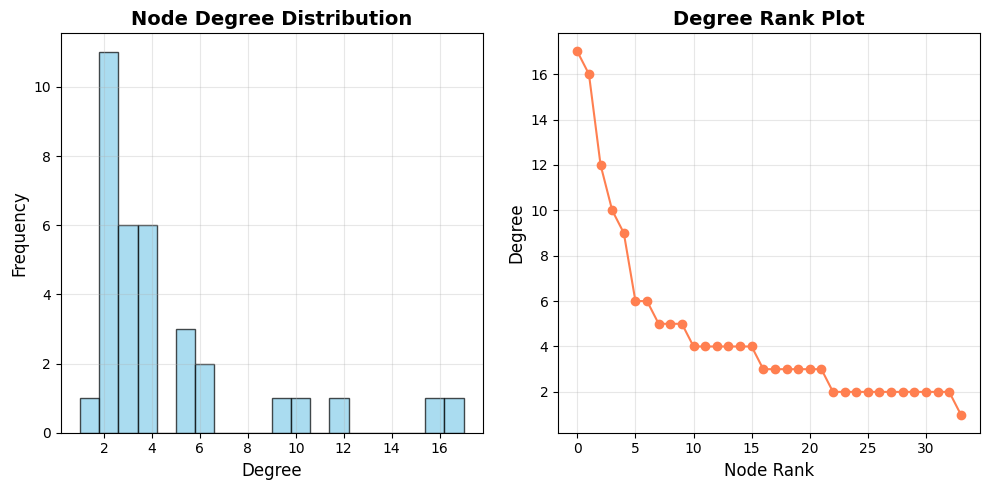

In [9]:
# Degree distribution visualization
plt.figure(figsize=(10, 5))
degrees = [G.degree(n) for n in G.nodes()]
plt.subplot(1, 2, 1)
plt.hist(degrees, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Degree', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Node Degree Distribution', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
degree_sequence = sorted(degrees, reverse=True)
plt.plot(degree_sequence, marker='o', linestyle='-', color='coral')
plt.xlabel('Node Rank', fontsize=12)
plt.ylabel('Degree', fontsize=12)
plt.title('Degree Rank Plot', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [10]:
# GCN Model for Node Classification
class GCN(nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, dropout=0.5):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index):
        # First GCN layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Second GCN layer
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

    def get_embeddings(self, x, edge_index):
        """Get node embeddings from the first layer"""
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        return x

In [11]:
# GraphSAGE Model
class GraphSAGE(nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, dropout=0.5):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(num_features, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

    def get_embeddings(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        return x

In [17]:
# GAT Model
class GAT(nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, heads=8, dropout=0.6):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_features, hidden_dim, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_dim * heads, num_classes, heads=1, concat=False, dropout=dropout)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

    def get_embeddings(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        return x

In [14]:
# Prepare data for node classification task
print("Task 1: Node Classification Setup")
print("="*60)

# Create train/val/test masks
num_nodes = data.num_nodes
train_ratio, val_ratio = 0.6, 0.2

# Shuffle nodes
perm = torch.randperm(num_nodes)
train_size = int(train_ratio * num_nodes)
val_size = int(val_ratio * num_nodes)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[perm[:train_size]] = True
val_mask[perm[train_size:train_size+val_size]] = True
test_mask[perm[train_size+val_size:]] = True

print(f"Training nodes: {train_mask.sum().item()}")
print(f"Validation nodes: {val_mask.sum().item()}")
print(f"Test nodes: {test_mask.sum().item()}")

# Add masks to data object
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

Task 1: Node Classification Setup
Training nodes: 20
Validation nodes: 6
Test nodes: 8


In [15]:
# Initialize model for node classification
model_type = 'GCN'  # Options: 'GCN', 'GraphSAGE', 'GAT'
hidden_dim = 16

if model_type == 'GCN':
    model = GCN(data.num_node_features, hidden_dim, dataset.num_classes, dropout=0.5)
elif model_type == 'GraphSAGE':
    model = GraphSAGE(data.num_node_features, hidden_dim, dataset.num_classes, dropout=0.5)
elif model_type == 'GAT':
    model = GAT(data.num_node_features, hidden_dim, dataset.num_classes, heads=4, dropout=0.6)

model = model.to(device)
data = data.to(device)

print(f"\nModel: {model_type}")
print(f"\n{model}")
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")


Model: GCN

GCN(
  (conv1): GCNConv(34, 16)
  (conv2): GCNConv(16, 4)
)

Total parameters: 628


In [18]:
# Training function
def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Evaluation function
@torch.no_grad()
def evaluate(model, data, mask):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out[mask].argmax(dim=1)
    correct = pred.eq(data.y[mask]).sum().item()
    acc = correct / mask.sum().item()
    return acc

# Training setup
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.NLLLoss()

# Training loop
num_epochs = 200
train_losses = []
val_accs = []
train_accs = []
print("\nStarting Training...")
print("="*60)

for epoch in range(num_epochs):
    loss = train(model, data, optimizer, criterion)
    train_acc = evaluate(model, data, data.train_mask)
    val_acc = evaluate(model, data, data.val_mask)

    train_losses.append(loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    if (epoch + 1) % 20 == 0:
        print(f'Epoch {epoch+1:03d} | Loss: {loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}')

print("\nTraining Complete!")


Starting Training...
Epoch 020 | Loss: 1.1146 | Train Acc: 0.6500 | Val Acc: 1.0000
Epoch 040 | Loss: 0.6223 | Train Acc: 0.8500 | Val Acc: 1.0000
Epoch 060 | Loss: 0.4368 | Train Acc: 0.9500 | Val Acc: 1.0000
Epoch 080 | Loss: 0.2199 | Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 100 | Loss: 0.1760 | Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 120 | Loss: 0.2154 | Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 140 | Loss: 0.1375 | Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 160 | Loss: 0.1065 | Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 180 | Loss: 0.0417 | Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 200 | Loss: 0.0974 | Train Acc: 1.0000 | Val Acc: 1.0000

Training Complete!


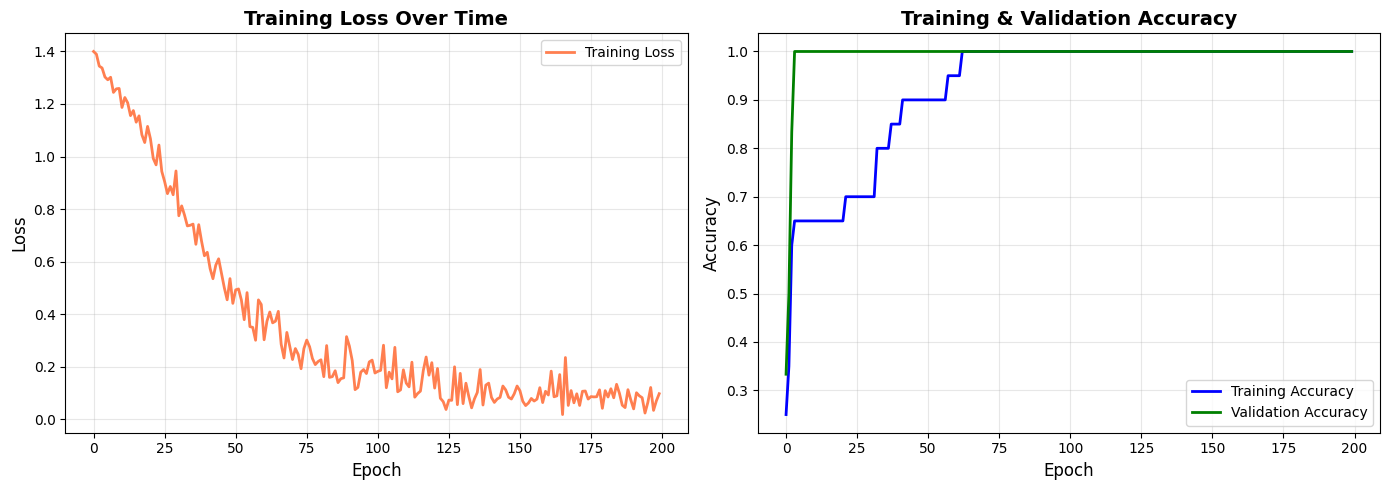

In [19]:
# Plot training curves
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='coral', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss Over Time', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy', color='blue', linewidth=2)
plt.plot(val_accs, label='Validation Accuracy', color='green', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [20]:
# Get node embeddings
model.eval()
with torch.no_grad():
    embeddings = model.get_embeddings(data.x, data.edge_index)
    embeddings_np = embeddings.cpu().numpy()

print(f"Node embeddings shape: {embeddings_np.shape}")

Node embeddings shape: (34, 16)


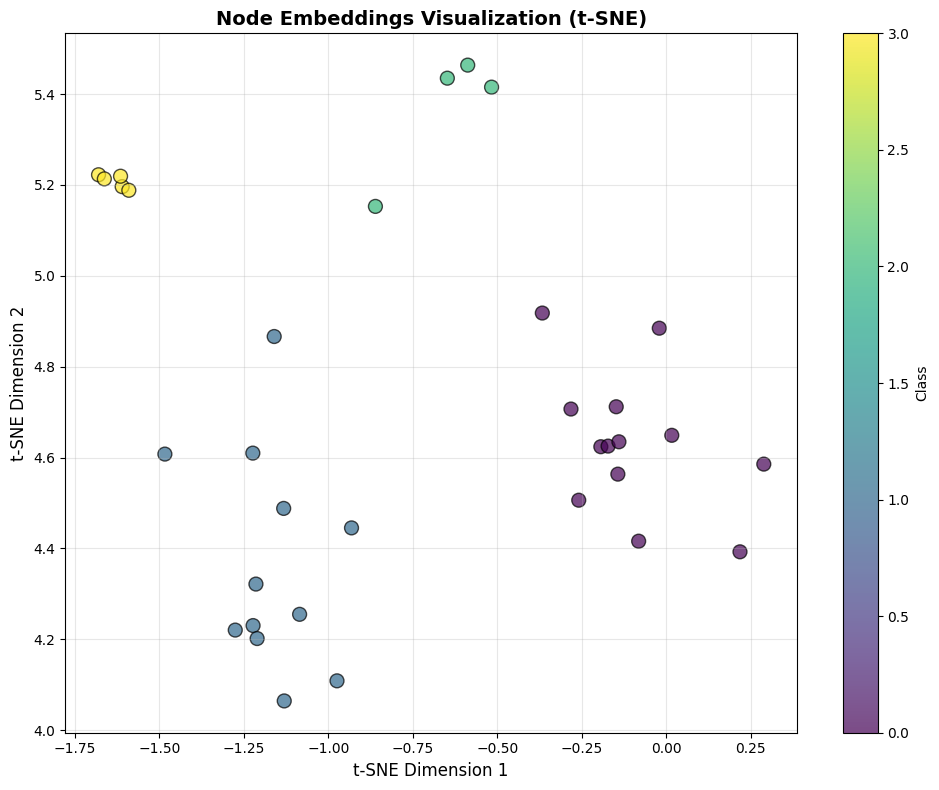

In [21]:
# Visualize embeddings using t-SNE
if embeddings_np.shape[1] > 2:
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings_np)
else:
    embeddings_2d = embeddings_np

plt.figure(figsize=(10, 8))
labels = data.y.cpu().numpy()
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                     c=labels, cmap='viridis', s=100, alpha=0.7, edgecolors='black')
plt.colorbar(scatter, label='Class')
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.title('Node Embeddings Visualization (t-SNE)', fontsize=14,
          fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [22]:
# Final evaluation on test set
test_acc = evaluate(model, data, data.test_mask)

# Get predictions
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)

# Calculate metrics
from sklearn.metrics import classification_report, confusion_matrix

y_true = data.y[data.test_mask].cpu().numpy()
y_pred = pred[data.test_mask].cpu().numpy()

print("\n" + "="*60)
print("FINAL EVALUATION RESULTS")
print("="*60)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"\nClassification Report:\n")
print(classification_report(y_true, y_pred))


FINAL EVALUATION RESULTS

Test Accuracy: 1.0000

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



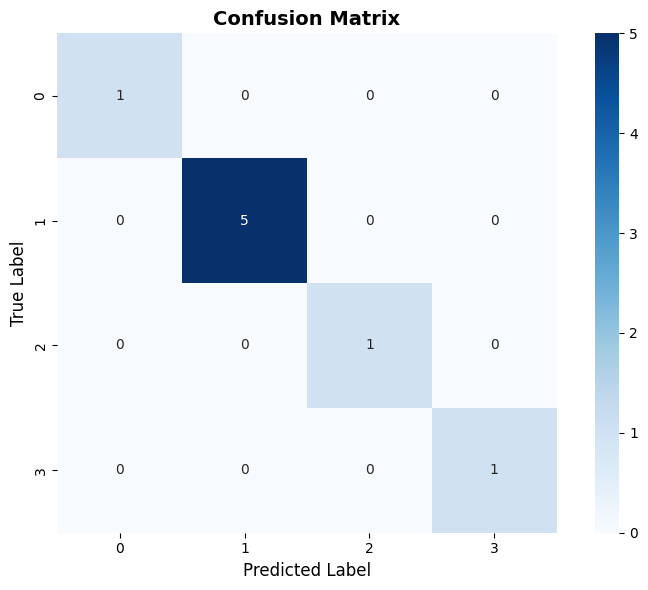

In [23]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, square=True)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

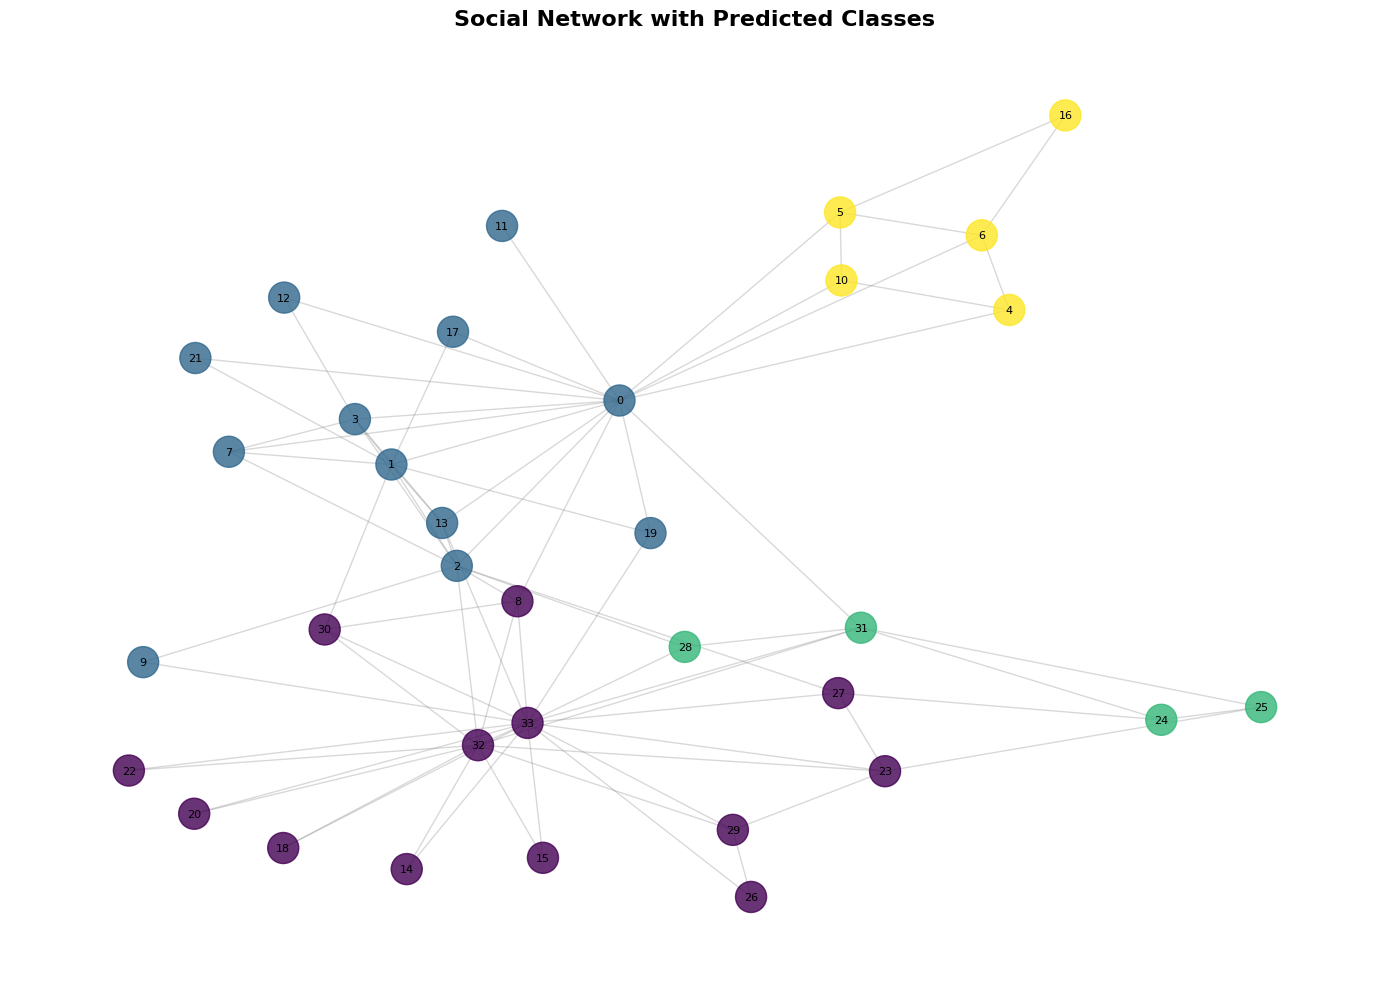

In [24]:
# Visualize graph with predicted classes
G_vis = to_networkx(data, to_undirected=True)

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G_vis, seed=42)

# Color by predicted class
pred_colors = pred.cpu().numpy()
node_colors = [pred_colors[node] for node in G_vis.nodes()]

nx.draw_networkx_nodes(G_vis, pos,
                      node_color=node_colors,
                      cmap='viridis',
                      node_size=500,
                      alpha=0.8)
nx.draw_networkx_edges(G_vis, pos, alpha=0.3, edge_color='gray')
nx.draw_networkx_labels(G_vis, pos, font_size=8)

plt.title('Social Network with Predicted Classes', fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

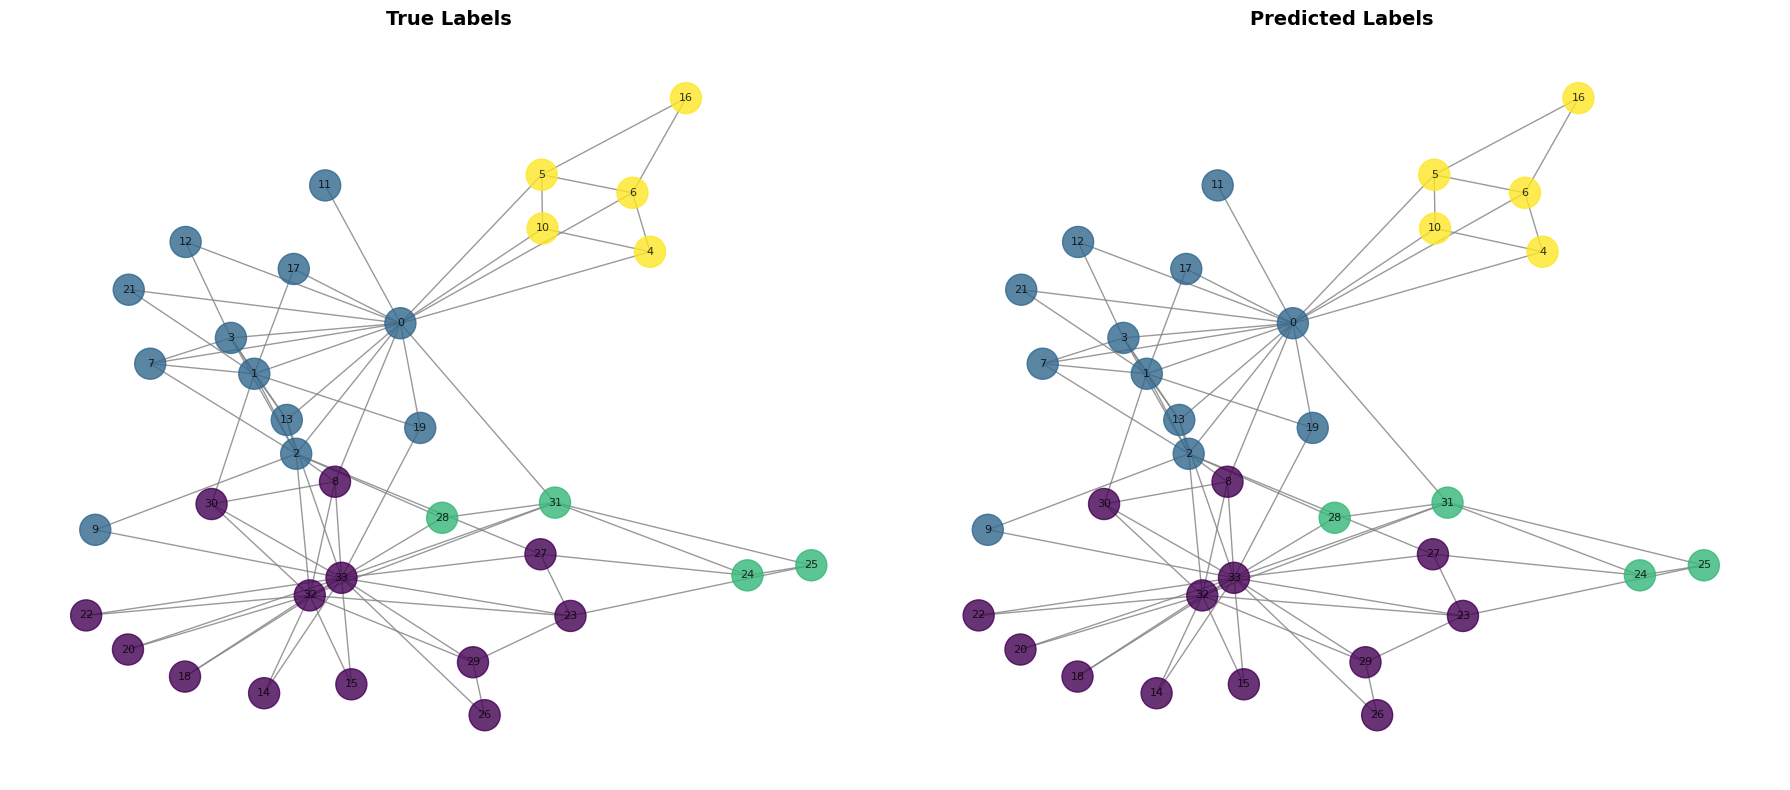

In [25]:
# Compare true vs predicted labels
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# True labels
true_colors = data.y.cpu().numpy()
node_colors_true = [true_colors[node] for node in G_vis.nodes()]

nx.draw_networkx(G_vis, pos,
                node_color=node_colors_true,
                cmap='viridis',
                node_size=500,
                edge_color='gray',
                with_labels=True,
                font_size=8,
                alpha=0.8,
                ax=axes[0])
axes[0].set_title('True Labels', fontsize=14, fontweight='bold')
axes[0].axis('off')

# Predicted labels
nx.draw_networkx(G_vis, pos,
                node_color=node_colors,
                cmap='viridis',
                node_size=500,
                edge_color='gray',
                with_labels=True,
                font_size=8,
                alpha=0.8,
                ax=axes[1])
axes[1].set_title('Predicted Labels', fontsize=14, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [26]:
# Example: Link Prediction Task
print("\nBonus: Link Prediction Example")
print("="*60)

# Split edges for link prediction
data_link = train_test_split_edges(data)

print(f"Training edges: {data_link.train_pos_edge_index.shape[1]}")
print(f"Validation edges: {data_link.val_pos_edge_index.shape[1]}")
print(f"Test edges: {data_link.test_pos_edge_index.shape[1]}")


Bonus: Link Prediction Example
Training edges: 136
Validation edges: 3
Test edges: 7


In [27]:
# Link Prediction Model
class LinkPredictionGNN(nn.Module):
    def __init__(self, num_features, hidden_dim):
        super(LinkPredictionGNN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_index):
        # Dot product decoder
        return (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)

    def forward(self, x, edge_index):
        z = self.encode(x, edge_index)
        return z

# Initialize link prediction model
link_model = LinkPredictionGNN(data.num_node_features, hidden_dim=32)
link_model = link_model.to(device)
print(f"\nLink Prediction Model initialized with {sum(p.numel() for p in link_model.parameters())} parameters")


Link Prediction Model initialized with 2176 parameters
